# Art Painting 이미지를 사용한 정확도 올리기

## <문제>

제공된 훈련데이터를 사용하여 모델을 훈련한 후 테스트 데이터에 대한 예측 카테고리 값을 csv파일로 제출하세요.

아래의 훈련데이터만을 사용하여 각 카테고리별로 분류가 잘 되도록 신경망을 구성하세요.
각 카테고리 별 정답 값은 아래와 같습니다.

- 'dog' : 0
- 'elephant' : 1
- 'giraffe' : 2
- 'guitar' : 3
- 'horse' : 4
- 'house' : 5
- 'person' : 6

## <목적>

주어진 데이터를 활용하여 정확도를 최대로 높이세요.

## 데이터 설명

데이터 셋은 art painting으로 구성되어 있으며 7개의 카테고리로 구분되어 있습니다.

7개의 카테고리로는 classes에서 정의한 dog, elephant, giraffe, guitar, horse, house, person를 포함합니다.

하나의 이미지의 사이즈는 [3(Channel) * 227(Width) * 227(Height)]이며 각 카테고리 별 예시 이미지는 아래에서 확인할 수 있습니다.

훈련 데이터는 art painting 1698장이며 테스트 데이터는 art painting 350장입니다.

## <최종 제출 파일과 코드>

- submission.csv

최종 제출 파일은 label 필드를 가지는 csv파일이며 테스트 데이터의 label을 값으로 가져야 합니다.
최종 제출 파일은 test_answer(sample).csv 파일과 같은 크기여야 하고 label값을 채워야합니다.

- ipynb 파일 (주피터 노트북)

- 최종 제출한 결과를 확인할 수 있는 소스 코드와 코드에 대한 간략한 설명을 STEP 4에서 파일 업로드 버튼을 클릭하여 제출합니다.

- 소스 코드에 대한 간략한 설명은 다음을 포함해야 합니다.

    - 문제를 어떤 관점에서 정의하였는지

    - 문제 해결 위해 만든 모델에 대한 설명과 그 모델을 선택한 이유

- .py 파일이나 .R 파일은 받지 않습니다.

submission.csv과 ipynb 파일을 모두 제출하지 않을 경우 탈락처리됩니다.

## <데이터 관련 안내>

train 데이터 안에는 각 라벨별로 폴더가 나뉘어져 있으며 각 폴더 안의 파일을 사용하여 학습하여야 합니다.

test 데이터는 라벨별로 폴더가 나뉘어져있지 않으며 임의의 순서대로 이미지가 섞여있습니다.
최종 제출물의 경우 데이터의 순서가 오름차순으로 정렬되어 있습니다. 이 순서대로 각 이미지에 대한 라벨 값을 작성하여 제출하세요.

## <채점 방식>

테스트 데이터에서 추정한 label 값을 사용해 정확도를 구하고 이를 기준으로 채점합니다.

In [122]:
!nvidia-smi

Sun May 23 17:37:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.59       Driver Version: 462.59       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3070   WDDM  | 00000000:07:00.0  On |                  N/A |
|  0%   35C    P8    17W / 240W |   6305MiB /  8192MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [123]:
%conda info


     active environment : deeplearning38
    active env location : C:\Users\chlje\anaconda3\envs\deeplearning38
            shell level : 2
       user config file : C:\Users\chlje\.condarc
 populated config files : C:\Users\chlje\.condarc
          conda version : 4.10.1
    conda-build version : 3.21.4
         python version : 3.8.8.final.0
       virtual packages : __cuda=11.2=0
                          __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\chlje\anaconda3  (writable)
      conda av data dir : C:\Users\chlje\anaconda3\etc\conda
  conda av metadata url : https://repo.anaconda.com/pkgs/main
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
     

# EDA

In [124]:
import os, sys
from pathlib import Path
from glob import glob

In [125]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
import numpy as np
import pandas as pd

In [127]:
import json
import pickle

In [128]:
import matplotlib.image as mpimg
from PIL import Image

In [129]:
from tqdm import tqdm, trange
# from tqdm.notebook import tqdm
from time import time

In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.__version__

'1.7.1'

In [131]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device # Always check cudatoolkit version!

device(type='cuda', index=0)

In [132]:
from torch.utils.data import Subset, Dataset, DataLoader

In [133]:
import cv2

In [134]:
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [135]:
import torchvision
import timm

In [136]:
import wandb

wandb.login()

True

In [191]:
batch_size = 16
# num_workers = 8
shuffle = True
pin_memory = torch.cuda.is_available()
drop_last = True

In [245]:
epochs = 15
lr = 1e-5

In [246]:
# wandb.init(
#     project="programmers_image_cls",
#     config={
        
#     }
# )

## Load Data

In [247]:
data_path = Path('.').resolve() / "data"
train_path = data_path / "train"
test_path = data_path / "test" / "0"
output_path = data_path / "output"
processed_path = output_path / "processed"

In [248]:
train_l = list(train_path.glob('**/*'))
train_l = [p for p in train_l if p.is_file()]
train_l[:10]

[WindowsPath('E:/VSCodeProjects/programmers_ml/data/train/dog/pic_001.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/train/dog/pic_002.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/train/dog/pic_003.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/train/dog/pic_004.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/train/dog/pic_005.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/train/dog/pic_006.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/train/dog/pic_007.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/train/dog/pic_008.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/train/dog/pic_009.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/train/dog/pic_010.jpg')]

In [249]:
len(train_l)

1698

In [250]:
test_l = list(test_path.glob("*"))
test_l = [p for p in test_l if p.is_file()]
test_l[:10]

[WindowsPath('E:/VSCodeProjects/programmers_ml/data/test/0/0001.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/test/0/0002.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/test/0/0003.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/test/0/0004.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/test/0/0005.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/test/0/0006.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/test/0/0007.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/test/0/0008.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/test/0/0009.jpg'),
 WindowsPath('E:/VSCodeProjects/programmers_ml/data/test/0/0010.jpg')]

In [251]:
len(test_l)

350

In [252]:
train_df = pd.DataFrame()
train_df.loc[:, "cat"] = [p.parts[-2] for p in train_l]
train_df.loc[:, "filepath"] = train_l

In [253]:
cat_code_d = {
    'dog' : 0,
    'elephant' : 1,
    'giraffe' : 2,
    'guitar' : 3,
    'horse' : 4,
    'house' : 5,
    'person' : 6,
}

In [254]:
train_df.loc[:, "cat_code"] = train_df.cat.map(cat_code_d)

In [255]:
train_df

,cat,filepath,cat_code
0,dog,E:\VSCodeProjects\programmers_ml\data\train\do...,0
1,dog,E:\VSCodeProjects\programmers_ml\data\train\do...,0
2,dog,E:\VSCodeProjects\programmers_ml\data\train\do...,0
3,dog,E:\VSCodeProjects\programmers_ml\data\train\do...,0
4,dog,E:\VSCodeProjects\programmers_ml\data\train\do...,0
...,...,...,...
1693,person,E:\VSCodeProjects\programmers_ml\data\train\pe...,6
1694,person,E:\VSCodeProjects\programmers_ml\data\train\pe...,6
1695,person,E:\VSCodeProjects\programmers_ml\data\train\pe...,6
1696,person,E:\VSCodeProjects\programmers_ml\data\train\pe...,6


C:\Users\chlje\anaconda3\envs\deeplearning38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cat', ylabel='count'>

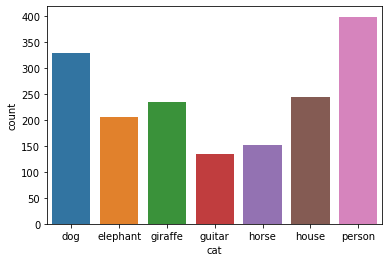

In [256]:
sns.countplot(train_df.cat)

In [257]:
train_df.to_pickle(processed_path / "train_df.pkl")

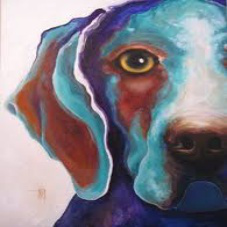

In [258]:
a = Image.open(train_df.filepath[0])
a

## 여러 파일들을 눈으로 EDA한 결과:

- 색깔이 다채로움
    - 흑백으로 바꿔버리는게 나을지도. 모델 입장에서 개가 색깔이 계속 바뀌면 헷갈림.
        - 찾아보니 pretrained가 RGB기 때문에 섯불리 첫 cnn layer 가중치 초기화시켜서 갈아끼웠다간 어그러지기 쉬움. 
        - pretrained weight들을 합쳐서 흑백처럼 만드는 방법이 있긴 함. 
        - 가진 data를 흑백으로 만드는 것은 transform에서 하므로 어렵지 않음.
- 물감때문에 현실보다 색 변화가 불연속적임
    - blur 해버려도 좋을 듯. 현실의 명암 반영.
        - albumentation해보면 됨. 
- 그림이 이미 crop된 상태임
    - 사실상 1 개의 대상만 있음. train data에 대한 crop은 불필요할 것으로 보임. 
- 그림마다 화풍이 상이함. 
    - 섣불리 cut mix했다가 큰일날 것 같음. 
    - 심각하게 추상화되어 그려진 경우가 많음. 실제보다 과장되게 그려져 그냥 알아보기 힘듦. 
    - 잘 모르겠으면 그냥 train dataset의 분포대로 찍는 것도 방법일 것 같음. 
        - 모델이 헷갈리기 쉬우므로 label smoothing loss를 써볼 수 있음. 
- 데이터 불균형이 있음
    - guitar보다 person이 3.5배가량 많음. 
        - focal loss를 써볼 수 있음. 
- 데이터가 적음
    - augmentation으로 데이터 자체를 늘려줄 필요도 있어보임. 

## 문제 정의

심하게 추상화된 그림은 어쩔 수 없다. 

그나마 실제처럼 그려진 그림을 최대한 사진처럼 transform 하여 사진으로 pretrained 된 모델에 넣어 fine tuning시켜 그림을 분류하자. 

# Dataset & DataLoader

In [259]:
class MyDataset(Dataset):
    """Art Image Dataset"""
    def __init__(self, pkl_path, transform=None, mean=None, std=None, val_ratio=0.2):
        super(MyDataset, self).__init__()
        self._pkl_path = pkl_path
        self._transform = transform
        
        self.mean = mean
        self.std = std

        self.val_ratio = val_ratio

        self.setup()
        self.calc_statistics()
    
    def setup(self):
        self.df = pd.read_pickle(self._pkl_path)
        ## Add more code ##

    def calc_statistics(self):
        has_stats = self.mean is not None and self.std is not None
        if not has_stats:
            print('Calculating statistics')
            
            sums = []
            squared = []
            for img_path in self.df.filepath:
                image = np.array(Image.open(img_path)).astype(np.int32)
                sums.append(image.mean(axis=(0, 1)))
                squared.append((image ** 2).mean(axis=(0, 1)))
            
            self.mean = np.mean(sums, axis=0) / 255
            self.std = (np.mean(squared, axis=0) - self.mean ** 2) ** 0.5 / 255

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        row = self.df.iloc[index, :] # Change ":" to column index if needed. 
        
        ## Add more code ##
        cat = row['cat']
        cat_code = row['cat_code']
        filepath = row['filepath'].as_posix()
        img = np.array(Image.open(filepath), dtype=np.float32)

        if self._transform:
#             img = self._transform(img)
            img = self._transform(image=img)['image']
            
        data = {'cat': cat, 'cat_code': cat_code, 'filepath': filepath, 'image': img}
        
        return data

    def __len__(self):
        return len(self.df)
    
    def split_dataset(self):
        n_val = int(len(self) * self.val_ratio)
        n_train = len(self) - n_val
        train_set, val_set = torch.utils.data.random_split(self, [n_train, n_val])

        return train_set, val_set

    @staticmethod
    def denormalize(image, mean, std):
        ## Add more code ##
        img_cp = image.copy()
        img_cp *= std
        img_cp += mean
        img_cp *= 255.0
        img_cp = np.clip(img_cp, 0, 255).astype(np.uint8)

        return img_cp

In [260]:
class TestDataset(Dataset):
    """TestDataset"""
    def __init__(self, test_path, transform=None):
        super(TestDataset, self).__init__()
        self.test_l = list(test_path.glob("*"))
        self.test_l = [p for p in self.test_l if p.is_file()]
        self._transform = transform
        
    def __getitem__(self, idx):
#         if torch.is_tensor(index):
#             index = index.tolist()
#             selected_l = [self.text_l[idx] for idx in index]
        
        selected = self.test_l[idx]
        img = np.array(Image.open(selected), dtype=np.float32)
        
        if self._transform:
            img = self._transform(image=img)["image"]
        
        data = {"image": img}
        
        return data

    def __len__(self):
        return len(self.test_l)

In [261]:
## torchvision.transforms 

# transform = transforms.Compose([
#     transform.ToTensor(),
# ])

In [262]:
## albumentations transforms

transform = A.Compose([
    A.transforms.Blur(),
#     A.transforms.ToGray(),
#     A.transforms.ToSepia(),
    ToTensorV2()
])

In [263]:
mydataset = MyDataset(
    pkl_path=processed_path / "train_df.pkl",
    transform=transform,
)

Calculating statistics


In [264]:
mydataset.mean

array([0.5556861 , 0.50740065, 0.45690217])

In [265]:
mydataset.std

array([0.62354242, 0.57679102, 0.54049936])

In [266]:
train_dataset, val_dataset = mydataset.split_dataset()

In [267]:
train_dataset[0]

{'cat': 'dog',
 'cat_code': 0,
 'filepath': 'E:/VSCodeProjects/programmers_ml/data/train/dog/pic_244.jpg',
 'image': tensor([[[ 59.4000,  59.0400,  57.8800,  ..., 188.2800, 188.9200, 189.8000],
          [ 59.4000,  59.1600,  58.1200,  ..., 188.6400, 189.2800, 190.2000],
          [ 59.4400,  59.3200,  58.5200,  ..., 189.8800, 190.2800, 191.2000],
          ...,
          [ 47.8400,  47.9600,  48.3200,  ...,  64.2800,  63.8000,  63.6000],
          [ 47.6000,  47.7600,  48.1200,  ...,  61.3200,  60.8800,  60.8000],
          [ 47.5600,  47.7200,  48.0400,  ...,  60.0000,  59.4800,  59.4000]],
 
         [[ 61.2000,  61.2400,  61.4800,  ...,  34.6000,  35.8000,  36.8000],
          [ 61.2000,  61.2800,  61.5200,  ...,  35.0800,  36.2000,  37.2000],
          [ 61.2400,  61.4400,  61.8000,  ...,  36.7200,  37.5200,  38.4000],
          ...,
          [ 47.8400,  47.9600,  48.1200,  ...,  41.8800,  41.1200,  40.4000],
          [ 47.6000,  47.7600,  47.9200,  ...,  40.6400,  40.0000,  39.

In [268]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
#     num_workers=num_workers,
    shuffle=shuffle,
    pin_memory=pin_memory,
    drop_last=drop_last
)
train_loader

In [269]:
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
#     num_workers=num_workers,
    shuffle=shuffle,
    pin_memory=pin_memory,
    drop_last=drop_last
)
val_loader

In [270]:
test_dataset = TestDataset(
    test_path=test_path,
    transform=transform
)

In [271]:
test_dataset[0]

{'image': tensor([[[ 58.,  57.,  67.,  ...,  39.,  56.,  53.],
          [ 49.,  50.,  56.,  ...,  45.,  44.,  28.],
          [ 43.,  49.,  51.,  ...,  51.,  43.,  37.],
          ...,
          [ 27.,  30.,  27.,  ..., 100.,  88.,  81.],
          [ 20.,  40.,  40.,  ..., 118.,  95.,  78.],
          [ 21.,  27.,  23.,  ..., 149., 119.,  92.]],
 
         [[116., 115., 125.,  ...,  74.,  93.,  90.],
          [104., 105., 111.,  ...,  80.,  79.,  64.],
          [ 98., 102., 104.,  ...,  83.,  78.,  71.],
          ...,
          [ 40.,  46.,  44.,  ...,  53.,  60.,  77.],
          [ 36.,  56.,  57.,  ...,  69.,  67.,  74.],
          [ 38.,  44.,  43.,  ...,  97.,  88.,  87.]],
 
         [[118., 117., 127.,  ...,  68.,  86.,  83.],
          [107., 108., 114.,  ...,  74.,  73.,  60.],
          [101., 106., 108.,  ...,  80.,  74.,  70.],
          ...,
          [ 31.,  36.,  34.,  ...,  37.,  38.,  48.],
          [ 26.,  46.,  47.,  ...,  54.,  45.,  45.],
          [ 28.,  34.,

In [272]:
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=pin_memory,
    drop_last=False,
)

test_loader

# Model

주어진 데이터가 적기 때문에 무조건 pretrained model을 써서 transfer learning을 시켜야 한다. 

내 로컬 pc에서 gpu로 돌릴 것이기 때문에 너무 무거운 모델은 안된다. 

--> pretrained efficientnet 선택 

In [273]:
timm_models_l = timm.list_models()
[x for x in timm_models_l if "tf" not in x and "efficient" in x]

['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_s']

In [274]:
# model_name = 'efficientnet_b4' # 느리고 성능 안좋음. 
model_name = 'efficientnet_b3_pruned'

In [300]:
model = timm.create_model(model_name, pretrained=True)
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv

In [301]:
model.num_classes

1000

In [302]:
model.num_features

1536

In [303]:
next(model.parameters()).device

device(type='cpu')

#TODO: 첫 레이어 weight load state로 불러와서 합치고, transform으로 togray했을 때 잘 되나 보기. 

In [279]:
class MyModel(nn.Module):
    """Some Information about MyModel"""
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)
        n_features = self.model.num_features
        self.img_classifier = timm.models.layers.ClassifierHead(n_features, num_classes)

    def forward(self, x):
        features = self.model.forward_features(x)
        x = self.img_classifier(features)

        return x

In [280]:
model = MyModel(model_name, 7).to(device)

In [281]:
next(model.parameters()).device

device(type='cuda', index=0)

## optimizer

In [282]:
optimizer = optim.AdamW(
    model.parameters(),
    lr=lr
)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0.01
)

In [283]:
# optimizer = optim.SGD(
#     model.parameters(),
#     lr=lr,
#     momentum=0.9
# )
# optimizer

## loss

In [284]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [285]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=3, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [286]:
# criterion = nn.CrossEntropyLoss()
# criterion

In [287]:
criterion = FocalLoss()
criterion

FocalLoss()

In [288]:
# criterion = LabelSmoothingLoss()
# criterion

In [289]:
log_interval = 100

## Train

ToGray 안했을 때 

In [290]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    matches = 0
    
    for i, data in tqdm(enumerate(train_loader, start=0)):
        if i == 0:
            print(f"*** Starting Epoch {epoch} ***")
        
        inputs = data['image']
        labels = data['cat_code']
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outs = model(inputs)
        preds = torch.argmax(outs, dim=-1)
        loss = criterion(outs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        matches += (preds == labels).sum().item()
        
        if (i+1) % log_interval == 0 or i == len(train_loader) - 1:
            train_loss = running_loss / log_interval
            train_acc = matches / batch_size / log_interval
            
            print(f"Epoch: {epoch+1}/{epochs} | {i+1}/{len(train_loader)}")
            print(f"training loss: {train_loss:4} || training accuracy: {train_acc:4}")
            
            running_loss = 0.0
            matches = 0

1it [00:00,  8.20it/s]

*** Starting Epoch 0 ***


84it [00:09,  9.18it/s]
1it [00:00,  9.17it/s]

Epoch: 1/15 | 84/84
training loss: 1.079021669626236 || training accuracy: 0.345625
*** Starting Epoch 1 ***


84it [00:09,  9.19it/s]
1it [00:00,  9.17it/s]

Epoch: 2/15 | 84/84
training loss: 0.7200729554891586 || training accuracy: 0.673125
*** Starting Epoch 2 ***


84it [00:09,  8.93it/s]
1it [00:00,  9.17it/s]

Epoch: 3/15 | 84/84
training loss: 0.4119222640991211 || training accuracy: 0.745
*** Starting Epoch 3 ***


84it [00:09,  9.05it/s]
1it [00:00,  9.17it/s]

Epoch: 4/15 | 84/84
training loss: 0.23692999087274075 || training accuracy: 0.77875
*** Starting Epoch 4 ***


84it [00:09,  8.89it/s]
1it [00:00,  8.81it/s]

Epoch: 5/15 | 84/84
training loss: 0.14998927246779203 || training accuracy: 0.79375
*** Starting Epoch 5 ***


84it [00:09,  9.02it/s]
1it [00:00,  9.09it/s]

Epoch: 6/15 | 84/84
training loss: 0.10845316853374243 || training accuracy: 0.795625
*** Starting Epoch 6 ***


84it [00:09,  8.97it/s]
1it [00:00,  9.09it/s]

Epoch: 7/15 | 84/84
training loss: 0.09444628788158298 || training accuracy: 0.799375
*** Starting Epoch 7 ***


84it [00:09,  9.26it/s]
1it [00:00,  9.35it/s]

Epoch: 8/15 | 84/84
training loss: 0.05983520961366594 || training accuracy: 0.81875
*** Starting Epoch 8 ***


84it [00:09,  9.26it/s]
1it [00:00,  9.35it/s]

Epoch: 9/15 | 84/84
training loss: 0.046424671392887834 || training accuracy: 0.8225
*** Starting Epoch 9 ***


84it [00:09,  9.27it/s]
1it [00:00,  9.26it/s]

Epoch: 10/15 | 84/84
training loss: 0.04160636509768665 || training accuracy: 0.82125
*** Starting Epoch 10 ***


84it [00:09,  9.28it/s]
1it [00:00,  8.93it/s]

Epoch: 11/15 | 84/84
training loss: 0.03986584485741332 || training accuracy: 0.82
*** Starting Epoch 11 ***


84it [00:09,  9.27it/s]
1it [00:00,  9.26it/s]

Epoch: 12/15 | 84/84
training loss: 0.02790178144816309 || training accuracy: 0.830625
*** Starting Epoch 12 ***


84it [00:09,  9.25it/s]
1it [00:00,  9.52it/s]

Epoch: 13/15 | 84/84
training loss: 0.028054566998034717 || training accuracy: 0.825
*** Starting Epoch 13 ***


84it [00:09,  9.23it/s]
1it [00:00,  9.52it/s]

Epoch: 14/15 | 84/84
training loss: 0.017452410934492946 || training accuracy: 0.833125
*** Starting Epoch 14 ***


84it [00:09,  9.21it/s]

Epoch: 15/15 | 84/84
training loss: 0.017726747271372006 || training accuracy: 0.831875


## Validation

In [291]:
with torch.no_grad():
    model.eval()
    val_running_loss = 0.0
    val_matches = 0

    for i, data in tqdm(enumerate(val_loader, start=0)):

        inputs = data['image']
        labels = data['cat_code']

        inputs = inputs.to(device)
        labels = labels.to(device)

        outs = model(inputs)
        preds = torch.argmax(outs, dim=-1)
        loss = criterion(outs, labels)

        val_running_loss += loss.item()
        val_matches += (preds == labels).sum().item()

        if (i+1) % log_interval == 0 or i == len(val_loader) - 1:
            val_loss = val_running_loss / log_interval
            val_acc = val_matches / batch_size / log_interval
            print(f"validation loss: {val_loss:4} || validation accuracy: {val_acc:4}")

            val_running_loss = 0.0
            val_matches = 0

21it [00:00, 23.58it/s]

validation loss: 0.024353093258105217 || validation accuracy: 0.19625


## Inference

In [292]:
answer_df = pd.DataFrame()
answer_df.loc[:, "index"] = range(len(test_l))
len(answer_df)

350

In [293]:
preds = []

with torch.no_grad():
    model.eval()

    for i, data in tqdm(enumerate(test_loader, start=0)):

        inputs = data['image']
        inputs = inputs.to(device)

        pred = model(inputs)
        pred = pred.argmax(dim=-1)
        preds.extend(pred.cpu().numpy())        

22it [00:00, 24.31it/s]


In [294]:
answer_df.loc[:, "answer value"] = preds

In [295]:
answer_df.to_csv(output_path / "submission.csv", index=False)

In [296]:
answer_df

,index,answer value
0,0,2
1,1,3
2,2,3
3,3,2
4,4,6
...,...,...
345,345,6
346,346,3
347,347,3
348,348,5


C:\Users\chlje\anaconda3\envs\deeplearning38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='answer value', ylabel='count'>

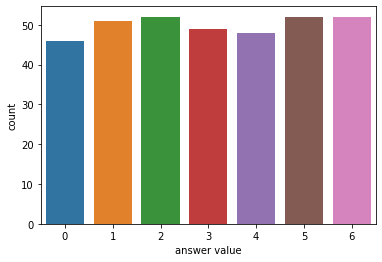

In [297]:
sns.countplot(answer_df["answer value"])

# 실험 기록

In [298]:
scores = [
    84.28571428571429, # baseline, CELoss
    87.14285714285714, # label smoothing loss
    91.42857142857143, # focal loss (선택)
    94.28571428571428, # epoch 10으로 올림 (선택)
    90.0, # batch 32로 올림 
    92.85714285714286, # batch 8로 줄임
    91.42857142857143, # batch 16으로 원상복구, epoch 20으로 올림
    90.0, # epoch 15
    
]

In [299]:
max(scores)

94.28571428571428